# phygnn-gan example

Here's a simple method for making a generative-adversarial network by using a binary classifier (discriminator) in the custom loss function provided to the phygnn model.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import binary_crossentropy

from rex import init_logger
from rex import Resource

from phygnn import PhysicsGuidedNeuralNetwork

In [2]:
init_logger('phygnn', log_level='INFO', log_file=None)

<Logger phygnn (INFO)>

## Import NSRDB solar data
The data includes 30-minute clearsky and all-sky GHI profiles from 9 locations for 1998-2019 inclusive.

In [3]:
with Resource('./nsrdb_data.h5') as res:
    df = pd.DataFrame({'ghi': res['ghi'], 'clearsky_ghi': res['clearsky_ghi']})

df['ghi'] = np.roll(df['ghi'], -7).astype(np.float32)
df['clearsky_ghi'] = np.roll(df['clearsky_ghi'], -7).astype(np.float32)
    
df.describe()

,ghi,clearsky_ghi
count,3.471120e+06,3.471120e+06
mean,1.865992e+02,2.387738e+02
std,2.741522e+02,3.133253e+02
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,3.240000e+02,4.760000e+02
max,1.100000e+03,1.100000e+03


<AxesSubplot:>

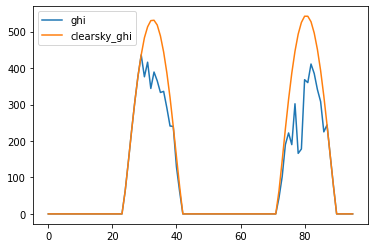

In [4]:
df.iloc[:96, :].plot()

## Shape the data
The data will be stored 2D arrays where each row is one day of data containing 30-minute profiles for clearsky and all-sky GHI along with some physical evaluations of the all-sky profile such as total cumulative GHI, maximum GHI, ramp rates, etc... 

In [5]:
n_days = int(len(df) / 48)
real_data = np.full((n_days, 96 + 4), np.nan, dtype=np.float32)

for i in range(n_days):
    i0 = i * 48
    i1 = i0 + 48
    real_data[i, 0:48] = df.iloc[i0:i1]['clearsky_ghi'].values
    
    # extra prediction features based on the physical attributes of the real solar profile
    real_data[i, 48] = df.iloc[i0:i1]['ghi'].values.max()
    real_data[i, 49] = df.iloc[i0:i1]['ghi'].values.sum()
    real_data[i, 50] = np.nanmax(np.abs(np.diff(df.iloc[i0:i1]['ghi'].values)))
    real_data[i, 51] = np.nanmean(np.abs(np.diff(df.iloc[i0:i1]['ghi'].values)))
    
    real_data[i, 52:] = df.iloc[i0:i1]['ghi'].values

# global variables for indexing
I0 = 48
I1 = 52

assert np.isnan(real_data).sum() == 0

In [6]:
test_index = sorted(np.random.choice(n_days, 200))
train_index = list(set(range(n_days)) - set(test_index))
test_data = real_data[test_index, :]
real_data = real_data[train_index, :]

display(test_data.shape, real_data.shape)

(200, 100)

(72116, 100)

i: 0 max: 436.0 sum: 5077.0 max_diff: 111.00 mean_diff: 22.30 
i: 1 max: 411.0 sum: 4273.0 max_diff: 190.00 mean_diff: 25.79 
i: 2 max: 390.0 sum: 4060.0 max_diff: 188.00 mean_diff: 30.38 
i: 3 max: 548.0 sum: 5852.0 max_diff: 148.00 mean_diff: 23.32 
i: 4 max: 574.0 sum: 6832.0 max_diff: 91.00 mean_diff: 24.43 


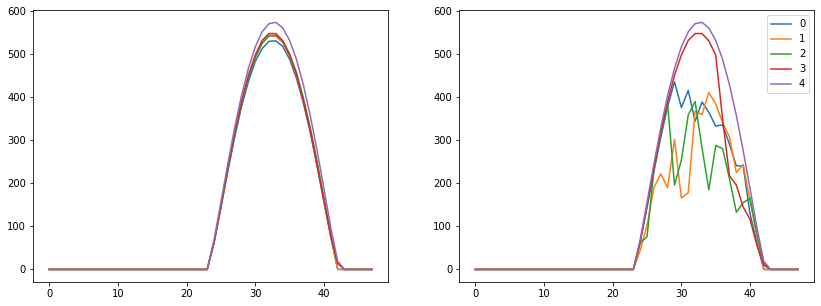

In [7]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i in range(5):
    ax1.plot(real_data[i, 0:48])
    ax2.plot(real_data[i, I1:])
    print('i: {} max: {} sum: {} max_diff: {:.2f} mean_diff: {:.2f} '
          .format(i, real_data[i, 48], real_data[i, 49], 
                  real_data[i, 50], real_data[i, 51]))
    
plt.legend(range(5))

In [8]:
g_features = real_data[:, 0:I1]  # clearsky profiles
g_known = real_data[:, I1:] # all-sky profiles

In [9]:
# clearsky profiles + [max_ghi, sum_ghi, max_diff, mean_diff]
g_features[0, :]

array([   0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,   63.      ,
        144.      ,  228.      ,  307.      ,  378.      ,  436.      ,
        483.      ,  513.      ,  530.      ,  531.      ,  518.      ,
        488.      ,  444.      ,  387.      ,  319.      ,  240.      ,
        157.      ,   75.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,  436.      , 5077.      ,
        111.      ,   22.297873], dtype=float32)

In [10]:
# all-sky profiles
g_known[0, :]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,  63., 144., 228., 307., 378., 436., 376., 416., 344.,
       389., 365., 333., 336., 291., 241., 240., 129.,  61.,   0.,   0.,
         0.,   0.,   0.,   0.], dtype=float32)

## Define the SolarGan class 
The SolarGan class is a subclass of the PhysicsGuidedNeuralNetwork framework. The subclass includes the custom GAN loss function and modifies the prediction function to constrain the generated solar profiles using the clearsky profiles

In [11]:
class SolarGan(PhysicsGuidedNeuralNetwork):
    """Subclass for solar data generation."""
    
    def predict(self, x, to_numpy=True, training=False):
        """Generate synthetic solar data and bound by the clearsky features (x)

        Parameters
        ----------
        x : np.ndarray
            Feature data in a 2D array (clearsky features + other physical constraints)
        to_numpy : bool
            Flag to convert output from tensor to numpy array
        training : bool
            Flag for predict() used in the training routine. This is used
            to freeze the BatchNormalization and Dropout layers.

        Returns
        -------
        y : tf.Tensor | np.ndarray
            Predicted solar profiles in a 2D array (n_days x 48_hours)
            made to be consistent with the clearsky input features
        """
        
        y = super().predict(x, to_numpy=to_numpy, training=training)
        
        if isinstance(y, tf.Tensor):
            y = tf.where(x[:, 0:48] == 0, x[:, 0:48], y)
            y = tf.where(y > x[:, 0:48], x[:, 0:48], y)
            y = tf.where(y < 0, 0, y)
            
        elif isinstance(y, np.ndarray):
            y = np.where(x[:, 0:48] == 0, x[:, 0:48], y)
            y = np.where(y > x[:, 0:48], x[:, 0:48], y)
            y = np.where(y < 0, 0, y)
    
        return y
    
    @staticmethod
    def make_d_features(y_gen):
        """Take the synthetic solar profiles from the generator and concatenate the extra 
        physical features (total solar, ramp rates, etc...) at column index [0:5]
        
        Parameters 
        ----------
        y_gen : tf.Tensor
            Generated synthetic solar data profiles of shape (n_days x 48_hours)
        
        Returns
        -------
        d_features_gen : tf.Tensor
            y_gen with additional evaluation features concatenated on axis=1
            atcolumn index [0:5]
        """

        if not isinstance(y_gen, tf.Tensor):
            y_gen = tf.convert_to_tensor(y_gen)

        d_features_gen_max = tf.expand_dims(tf.reduce_max(y_gen, axis=1), axis=1)
        d_features_gen_sum = tf.expand_dims(tf.reduce_sum(y_gen, axis=1), axis=1)
        diff = tf.abs(tf.experimental.numpy.diff(y_gen, axis=1))
        d_features_gen_max_diff = tf.expand_dims(tf.reduce_max(diff, axis=1), axis=1)
        d_features_gen_mean_diff = tf.expand_dims(tf.reduce_mean(diff, axis=1), axis=1)
        d_features_gen = tf.concat([d_features_gen_max, 
                                    d_features_gen_sum, 
                                    d_features_gen_max_diff, 
                                    d_features_gen_mean_diff, 
                                    y_gen], axis=1)

        return d_features_gen
    
    @classmethod
    def gan_loss(cls, model, y_true, y_gen, real_data, discriminator=None, i1=52):
        """Guiding loss function for training a phygnn-GAN.

        Parameters
        ----------
        model : PhysicsGuidedNeuralNetwork
            Instance of the phygnn model (generative model) at the current 
            point in training.
        y_true : np.ndarray
            Placeholder, not actually used in GAN formulation.
        y_gen : tf.Tensor
            Generated data from the prediction of the generative model
        real_data : np.ndarray
            Supplemental feature data. In this case, this is a 2D array of REAL
            30min clearsky and all-sky GHI daily profiles with shape (n_days, 96)
            where the first 48 columns are clearsky and the last 48 are all-sky
            real_data = np.hstack((arr_ghi, arr_cs_ghi))
        discriminator : tf.keras.Sequential
            Discriminator (adversary) binary classification model.
        i1 : int 
            Column indexer in real_data where the all-sky profiles start.

        Returns
        -------
        generator_loss : tf.Tensor
            A 0D tensor loss value inversely proportional to the 
            discriminator's classification error.
        """

        labels_gen = tf.zeros((len(y_gen), 1))
        labels_real = tf.ones((len(real_data), 1))

        d_features_gen = cls.make_d_features(y_gen)
        d_features = tf.concat([real_data[:, 48:], d_features_gen], axis=0)
        d_labels = tf.concat([labels_real, labels_gen], axis=0)

        indices = tf.range(start=0, limit=len(d_features), dtype=tf.int32)
        shuffled_indices = tf.random.shuffle(indices)
        d_features = tf.gather(d_features, shuffled_indices)
        d_labels = tf.gather(d_labels, shuffled_indices)

        d_out = discriminator(d_features)
        generator_loss = -1 * tf.reduce_mean(binary_crossentropy(d_labels, d_out))

        # penalize total daily ghi and ramp rate stats
        total_ghi_loss = tf.reduce_mean(tf.math.squared_difference(d_features_gen[:, 1], real_data[:, 49]))
        max_ramp_loss = tf.reduce_mean(tf.math.squared_difference(d_features_gen[:, 2], real_data[:, 50]))
        mean_ramp_loss = tf.reduce_mean(tf.math.squared_difference(d_features_gen[:, 3], real_data[:, 51]))

        generator_loss += 0.01 * (total_ghi_loss + max_ramp_loss + mean_ramp_loss)

        discriminator.fit(d_features, d_labels, 
                          batch_size=len(d_features), 
                          epochs=1, verbose=0)

        return generator_loss

In [12]:
SolarGan.seed(0)

## Define the discriminator using a simple Keras Sequential model

In [13]:
discriminator = keras.Sequential(
    [keras.Input(shape=(52)),
     layers.Dense(64, activation="relu"),
     layers.Dense(64, activation="relu"),
     layers.Dense(1, activation="sigmoid"),
    ]
)

discriminator.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

## Define the generator using our SolarGan class

In [14]:
hidden_layers = [{'units': 128, 'activation': 'relu', 'dropout': 0.5},
                 {'units': 128, 'activation': 'relu', 'dropout': 0.5},
                 {'units': 128, 'activation': 'relu', 'dropout': 0.5},
                 {'units': 128, 'activation': 'relu', 'dropout': 0.5},
                ]

generator = SolarGan(p_fun=SolarGan.gan_loss, 
                     hidden_layers=hidden_layers,
                     loss_weights=(0.0, 1.0), 
                     metric='mse',
                     learning_rate=0.0002,
                     n_features=52, 
                     n_labels=48,
                     name='Generator')

## Pretraining
This trains the generator against the known all-sky profiles so that we start with somewhat realistic solar profiles.

In [15]:
generator.set_loss_weights((1, 0))
generator.fit(g_features, g_known, real_data, n_batch=16, n_epoch=10, p_kwargs={'discriminator': discriminator, 'i1': I1})
generator.reset_history()

INFO - 2021-02-10 12:40:29,201 [phygnn.py:783] : Epoch 0 train loss: 5.04e+04 val loss: 3.14e+04 for "Generator"
INFO - 2021-02-10 12:40:30,970 [phygnn.py:783] : Epoch 1 train loss: 3.98e+04 val loss: 1.91e+04 for "Generator"
INFO - 2021-02-10 12:40:32,305 [phygnn.py:783] : Epoch 2 train loss: 3.26e+04 val loss: 2.06e+04 for "Generator"
INFO - 2021-02-10 12:40:33,911 [phygnn.py:783] : Epoch 3 train loss: 2.78e+04 val loss: 1.61e+04 for "Generator"
INFO - 2021-02-10 12:40:35,911 [phygnn.py:783] : Epoch 4 train loss: 2.23e+04 val loss: 1.17e+04 for "Generator"
INFO - 2021-02-10 12:40:37,931 [phygnn.py:783] : Epoch 5 train loss: 2.01e+04 val loss: 1.10e+04 for "Generator"
INFO - 2021-02-10 12:40:39,249 [phygnn.py:783] : Epoch 6 train loss: 1.66e+04 val loss: 9.74e+03 for "Generator"
INFO - 2021-02-10 12:40:40,624 [phygnn.py:783] : Epoch 7 train loss: 1.45e+04 val loss: 8.83e+03 for "Generator"
INFO - 2021-02-10 12:40:41,848 [phygnn.py:783] : Epoch 8 train loss: 1.27e+04 val loss: 8.80e+03

## GAN Training
This is the main training iteration with the full GAN loss with discriminator term

In [16]:
generator.set_loss_weights((0, 1))
generator.fit(g_features, g_known, real_data, n_batch=16, n_epoch=100, p_kwargs={'discriminator': discriminator, 'i1': I1})

INFO - 2021-02-10 12:40:47,116 [phygnn.py:783] : Epoch 0 train loss: 2.40e+04 val loss: 1.27e+05 for "Generator"
INFO - 2021-02-10 12:40:49,890 [phygnn.py:783] : Epoch 1 train loss: 2.00e+04 val loss: 1.18e+05 for "Generator"
INFO - 2021-02-10 12:40:53,251 [phygnn.py:783] : Epoch 2 train loss: 1.92e+04 val loss: 9.47e+04 for "Generator"
INFO - 2021-02-10 12:40:55,893 [phygnn.py:783] : Epoch 3 train loss: 1.66e+04 val loss: 1.02e+05 for "Generator"
INFO - 2021-02-10 12:40:59,436 [phygnn.py:783] : Epoch 4 train loss: 1.68e+04 val loss: 9.60e+04 for "Generator"
INFO - 2021-02-10 12:41:02,554 [phygnn.py:783] : Epoch 5 train loss: 1.44e+04 val loss: 9.25e+04 for "Generator"
INFO - 2021-02-10 12:41:05,350 [phygnn.py:783] : Epoch 6 train loss: 1.46e+04 val loss: 9.47e+04 for "Generator"
INFO - 2021-02-10 12:41:07,917 [phygnn.py:783] : Epoch 7 train loss: 1.37e+04 val loss: 8.82e+04 for "Generator"
INFO - 2021-02-10 12:41:10,531 [phygnn.py:783] : Epoch 8 train loss: 1.33e+04 val loss: 7.90e+04

<AxesSubplot:xlabel='epoch'>

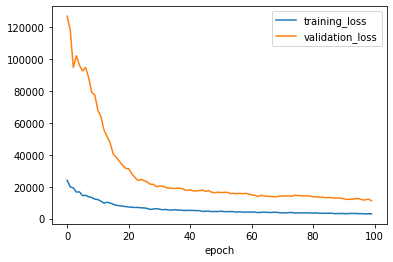

In [17]:
generator.history[['training_loss', 'validation_loss']].plot()

## Test data evaluation

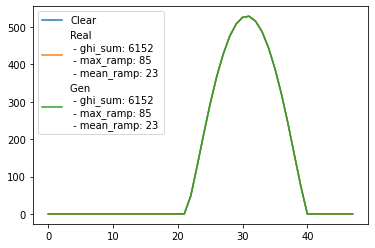

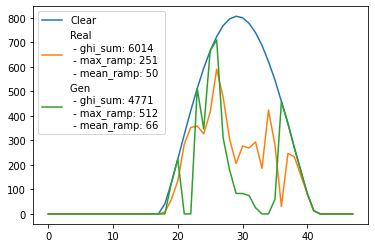

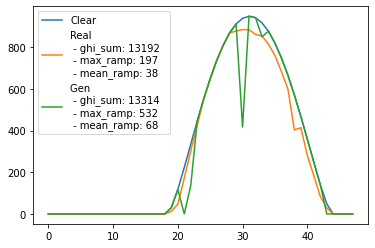

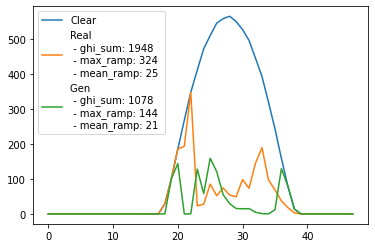

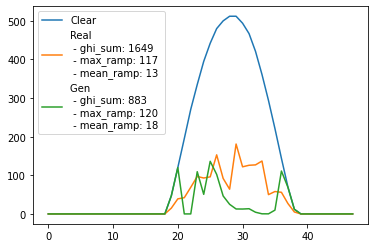

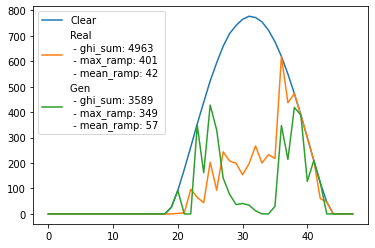

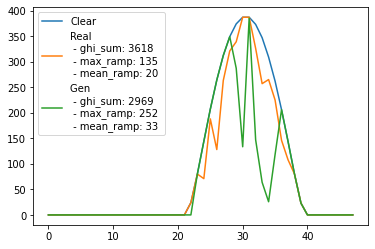

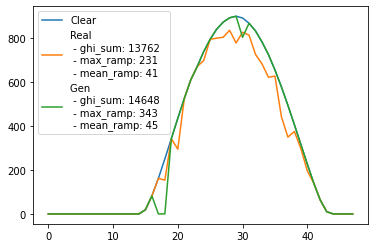

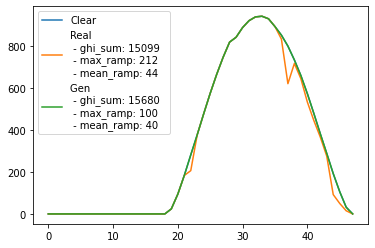

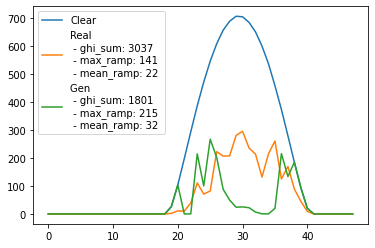

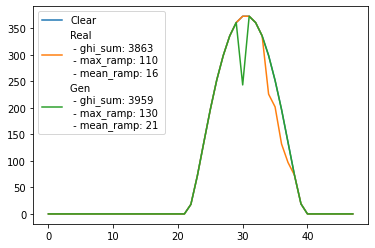

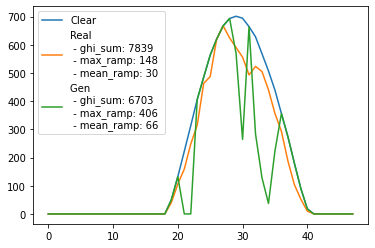

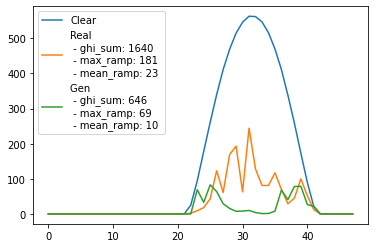

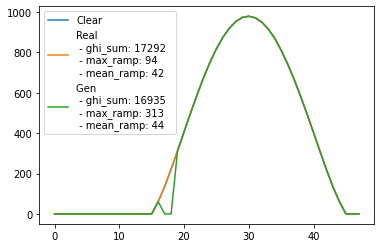

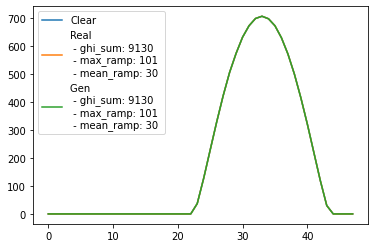

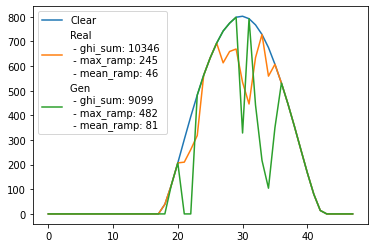

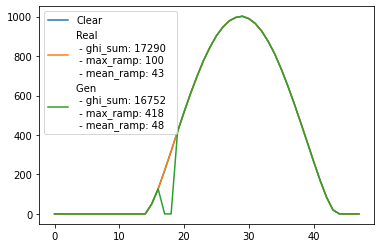

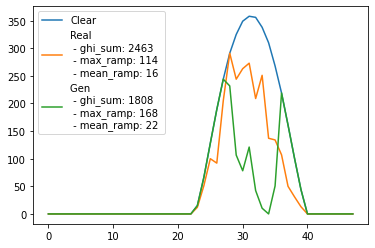

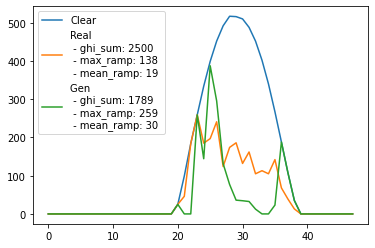

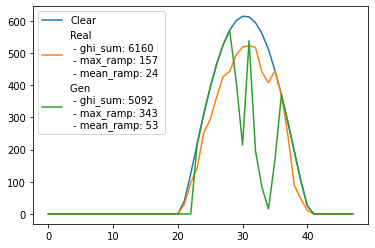

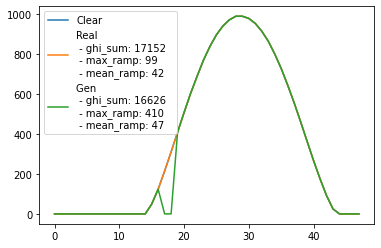

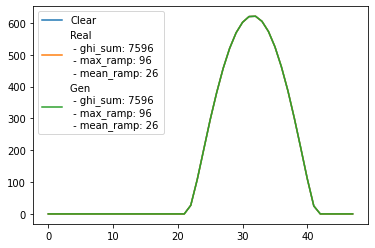

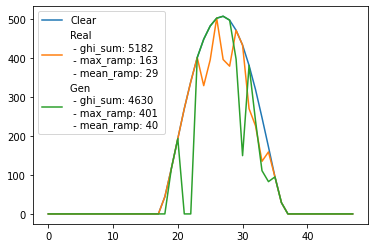

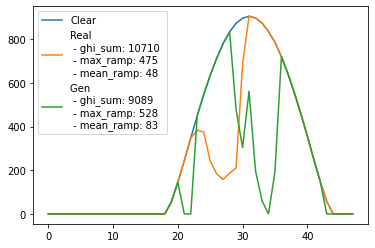

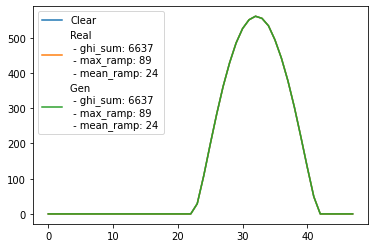

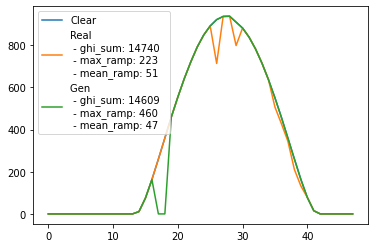

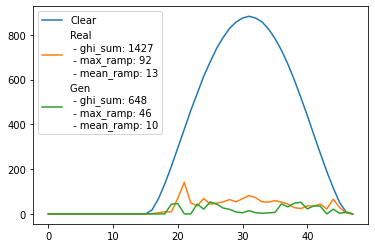

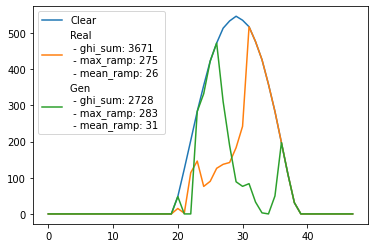

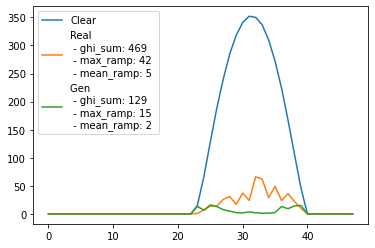

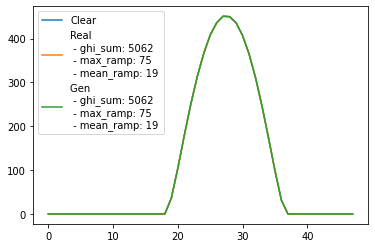

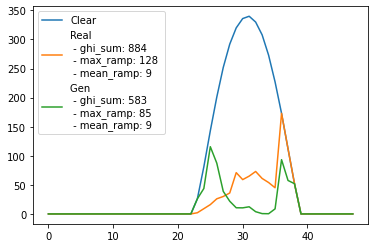

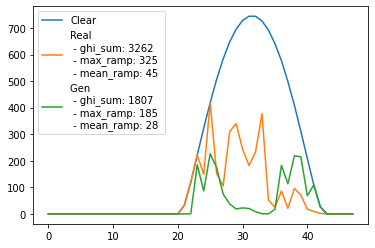

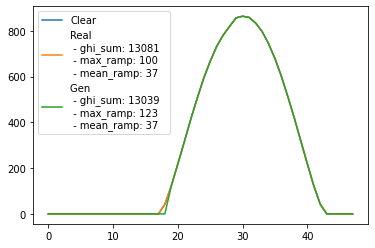

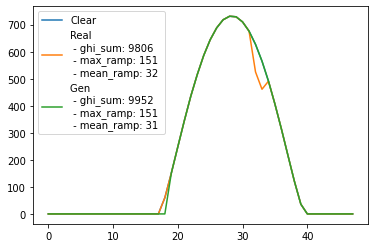

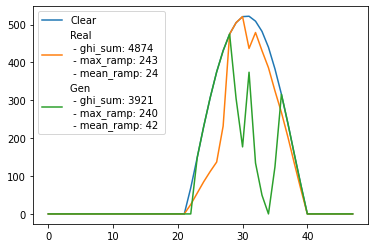

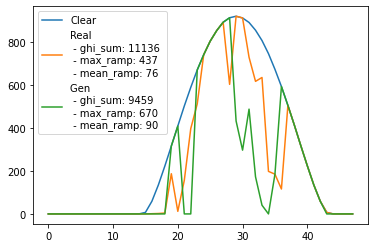

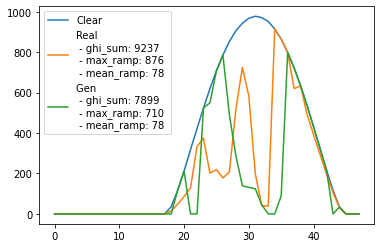

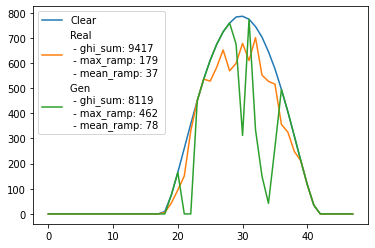

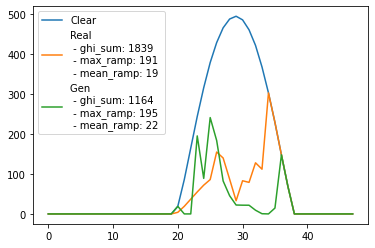

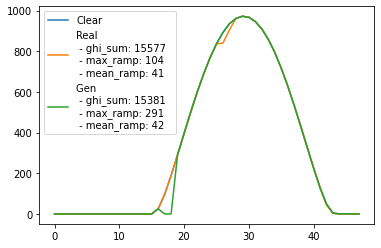

In [18]:
features = test_data[:, :I1]
generated = generator.predict(features)
generated = SolarGan.make_d_features(generated)

for i in range(0, len(test_data), 5):
    plt.plot(test_data[i, 0:48])
    plt.plot(test_data[i, I1:])
    plt.plot(generated[i, 4:])
    plt.legend(['Clear',
                'Real \n - ghi_sum: {:.0f} \n - max_ramp: {:.0f} \n - mean_ramp: {:.0f}'.format(test_data[i, 49], test_data[i, 50], test_data[i, 51]),
                'Gen \n - ghi_sum: {:.0f}  \n - max_ramp: {:.0f} \n - mean_ramp: {:.0f}'.format(generated[i, 1], generated[i, 2], generated[i, 3])])
    plt.show()
    plt.close()

## Discriminator evaluation 

This histogram will be Zero if discriminator is perfect

0.09813674


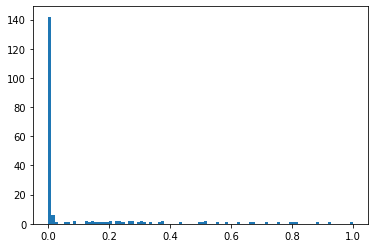

In [19]:
classification = discriminator(generated)
classification = classification.numpy().flatten()
print(classification.mean())
_ = plt.hist(classification, bins=100)

This histogram will be One if the discriminator is perfect

0.85302913


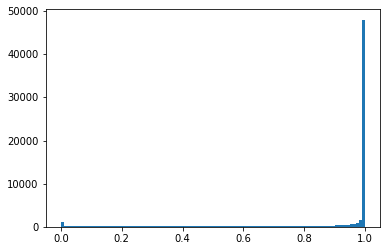

In [20]:
classification = discriminator(real_data[:, I0:]).numpy().flatten()
print(classification.mean())
_ = plt.hist(classification, bins=100)